Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [7]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [8]:
mainRoot = '/home/christophe/data/'
mainRoot = ''

pickle_file = mainRoot + 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [9]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [10]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Initialized
Test accuracy: 92.3%


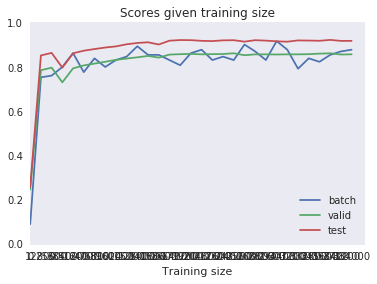

In [11]:
###################################################
########## Neural Networks with L2 regul ##########
###################################################

batch_size = 128
regul_param = 0.003
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # ONLY DIFF FOR SGD
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # ONLY DIFF FOR SGD
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    def forward_prop(inp):
        h1 = tf.nn.relu(tf.matmul(inp, weights_1) + biases_1)
        return tf.matmul(h1,weights_2) + biases_2

    # Training computation.
    logits = forward_prop(tf_train_dataset)
    regul_term = regul_param * ( tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) ) # L2 regularization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regul_term

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))


num_steps = 3001
data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            #print("Minibatch loss at step %d: %f" % (step, l))
            #print("Minibatch accuracy: %.1f%%" % batch_score)
            #print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

Initialized
Test accuracy: 88.3%


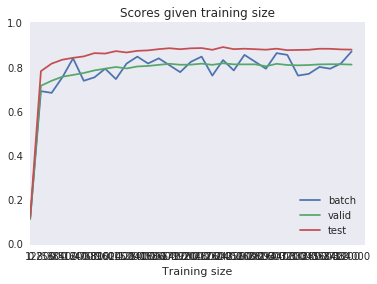

In [12]:
###################################################
############# Logistic with L2 regul ##############
###################################################

batch_size = 128
regul_param = 0.003

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # ONLY DIFF FOR SGD
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # ONLY DIFF FOR SGD
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    def forward_prop(inp):
        return tf.matmul(inp, weights) + biases

    # Training computation.
    logits = forward_prop(tf_train_dataset)
    regul_term = regul_param * tf.nn.l2_loss(weights) # L2 regularization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regul_term

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))


num_steps = 3001
data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            #print("Minibatch loss at step %d: %f" % (step, l))
            #print("Minibatch accuracy: %.1f%%" % batch_score)
            #print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Initialized
Test accuracy: 72.8%


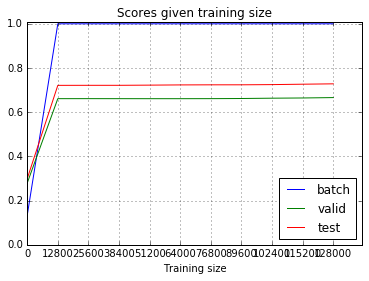

In [50]:
###################################################
########## Neural Networks with L2 regul ##########
#### Reducing the training size to cap examples ###
###################################################

batch_size = 128
regul_param = 0.003
hidden_nodes = 1024

cap = 200 # Reducing the training size to cap examples.
train_dataset_small = train_dataset[:cap,:]
train_labels_small = train_labels[:cap,:]

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # ONLY DIFF FOR SGD
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # ONLY DIFF FOR SGD
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    def forward_prop(inp):
        h1 = tf.nn.relu(tf.matmul(inp, weights_1) + biases_1)
        return tf.matmul(h1,weights_2) + biases_2

    # Training computation.
    logits = forward_prop(tf_train_dataset)
    regul_term = regul_param * ( tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) ) # L2 regularization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regul_term

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))


num_steps = 1001
data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_dataset_small.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_small[offset:(offset + batch_size), :]
        batch_labels = train_labels_small[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            #print("Minibatch loss at step %d: %f" % (step, l))
            #print("Minibatch accuracy: %.1f%%" % batch_score)
            #print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Initialized
Test accuracy: 87.3%


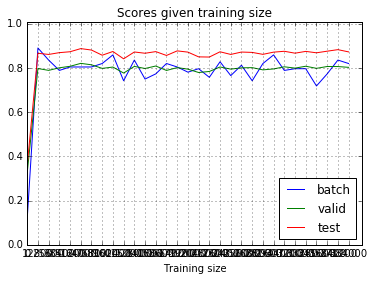

In [53]:
###################################################
####### Neural Networks with DropOut regul ########
###################################################

batch_size = 128
#regul_param = 0.003
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # ONLY DIFF FOR SGD
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # ONLY DIFF FOR SGD
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    def forward_prop_dropOut(inp):
        h1 = tf.nn.dropout( tf.nn.relu(tf.matmul(inp, weights_1) + biases_1), 0.5 )
        return tf.matmul(h1,weights_2) + biases_2

    def forward_prop(inp):
        h1 = tf.nn.relu(tf.matmul(inp, weights_1) + biases_1)
        return tf.matmul(h1,weights_2) + biases_2

    # Training computation.
    logits = forward_prop_dropOut(tf_train_dataset)
    #regul_term = regul_param * ( tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) ) # L2 regularization
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regul_term
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    #train_prediction = tf.nn.softmax(logits)
    train_prediction = tf.nn.softmax(forward_prop(tf_train_dataset))
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))


num_steps = 3001
data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            #print("Minibatch loss at step %d: %f" % (step, l))
            #print("Minibatch accuracy: %.1f%%" % batch_score)
            #print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

Initialized
Test accuracy: 78.5%


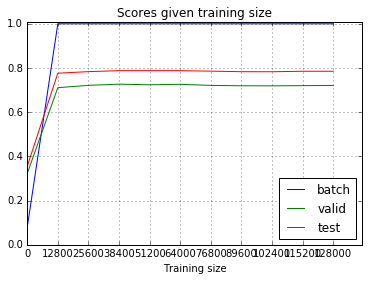

In [54]:
###################################################
####### Neural Networks with DropOut regul ########
################# Overfitting case ################
###################################################

cap = 200 # Reducing the training size to cap examples.
train_dataset_small = train_dataset[:cap,:]
train_labels_small = train_labels[:cap,:]

batch_size = 128
#regul_param = 0.003
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # ONLY DIFF FOR SGD
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # ONLY DIFF FOR SGD
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    def forward_prop_dropOut(inp):
        h1 = tf.nn.dropout( tf.nn.relu(tf.matmul(inp, weights_1) + biases_1), 0.5 )
        return tf.matmul(h1,weights_2) + biases_2

    def forward_prop(inp):
        h1 = tf.nn.relu(tf.matmul(inp, weights_1) + biases_1)
        return tf.matmul(h1,weights_2) + biases_2

    # Training computation.
    logits = forward_prop_dropOut(tf_train_dataset)
    #regul_term = regul_param * ( tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) ) # L2 regularization
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regul_term
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    #train_prediction = tf.nn.softmax(logits)
    train_prediction = tf.nn.softmax(forward_prop(tf_train_dataset))
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))


num_steps = 1001
data = np.ndarray(shape=(1+num_steps//100,4), dtype=np.float32)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_small.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_small[offset:(offset + batch_size), :]
        batch_labels = train_labels_small[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            batch_score = accuracy(predictions, batch_labels)
            valid_score = accuracy(valid_prediction.eval(), valid_labels)
            test_score = accuracy(test_prediction.eval(), test_labels)
            data[step//100,:] = [step*batch_size, batch_score/100, valid_score/100, test_score/100]
            #print("Minibatch loss at step %d: %f" % (step, l))
            #print("Minibatch accuracy: %.1f%%" % batch_score)
            #print("Validation accuracy: %.1f%%" % valid_score)
    print("Test accuracy: %.1f%%" % test_score)


fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1:4])
ax.set_title('Scores given training size')
ax.legend(('batch','valid', 'test'), loc='lower right')
ax.set_xticks(data[:,0])
ax.set_xlabel('Training size')
ax.set_ylim(0,1.01)
ax.grid()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
